In [1]:
import cranet
from cranet import nn, optim
from cranet.nn import functional as F
from cranet.data import Dataset, DataLoader

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

import itertools
import os

print(cranet.__version__)

0.1.3


In [2]:
class MnistDataset(Dataset):
    train_img = 'train-images-idx3-ubyte'
    train_lab = 'train-labels-idx1-ubyte'
    test_img = 't10k-images-idx3-ubyte'
    test_lab = 't10k-labels-idx1-ubyte'

    def __init__(self, root, mode, transform=None, transform_target=None):
        self.mode = mode
        self.transform = transform
        self.transform_target = transform_target
        self.images = []
        self.labels = []
        self._load_data(os.path.join(root, 'MNIST', 'raw'))

    def _load_data(self, data_dir):
        if self.mode == 'train':
            image_file = os.path.join(data_dir, self.train_img)
            label_file = os.path.join(data_dir, self.train_lab)
        elif self.mode == 'test':
            image_file = os.path.join(data_dir, self.test_img)
            label_file = os.path.join(data_dir, self.test_lab)
        else:
            raise RuntimeError('mode must be train or test')

        with open(image_file, 'rb') as f:
            f.read(4)  # magic
            self.size = int.from_bytes(f.read(4), "big")
            r = int.from_bytes(f.read(4), "big")
            c = int.from_bytes(f.read(4), "big")
            for _ in range(self.size):
                mat = []
                for i in range(r):
                    mat.append([])
                    for j in range(c):
                        mat[i].append(int.from_bytes(f.read(1), "big"))
                self.images.append(np.array(mat))

        with open(label_file, 'rb') as f:
            f.read(4)  # magic
            sz = int.from_bytes(f.read(4), "big")  # size
            assert self.size == sz
            for _ in range(self.size):
                lab = np.array(int.from_bytes(f.read(1), "big"))
                self.labels.append(lab)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        img = self.images[idx]
        lab = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)
        if self.transform_target is not None:
            lab = self.transform_target(lab)

        return img, lab


In [3]:
def trans(x):
    x = x.reshape(28*28)
    return cranet.as_tensor(x)


def trans_lab(x):
    return cranet.as_tensor(x)


train_ds = MnistDataset('data', 'train', trans, trans_lab)
test_ds = MnistDataset('data', 'test', trans, trans_lab)

In [4]:
train_ld = DataLoader(train_ds, 64)
test_ld = DataLoader(test_ds, 1000)

In [5]:
sample_image_batch, sample_label_batch = next(iter(train_ld))
sample_image = sample_image_batch.numpy()[0]
sample_label = sample_label_batch.numpy()[0]

In [6]:
print(sample_image_batch.shape)
print(sample_label_batch.shape)

(64, 784)
(64,)


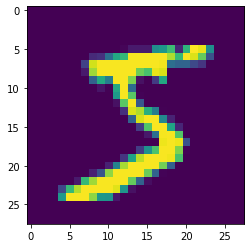

In [7]:
plt.imshow(sample_image.reshape(28, 28))

In [8]:
print(sample_label)

5


In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l0 = nn.Linear(28 * 28, 64)
        self.l1 = nn.Linear(64, 64)
        self.l2 = nn.Linear(64, 32)
        self.final = nn.Linear(32, 10)

    def forward(self, x: cranet.Tensor) -> cranet.Tensor:
        x = self.l0(x)
        x = F.sigmoid(x)
        x = self.l1(x)
        x = F.sigmoid(x)
        x = self.l2(x)
        x = F.sigmoid(x)
        x = self.final(x)
        x = F.log_softmax(x, dim=1)
        return x


In [ ]:
model = Model()

In [10]:
print(model)

Model(
  (l0): Linear(in_features=784, out_features=64, bias=True)
  (l1): Linear(in_features=64, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=32, bias=True)
  (final): Linear(in_features=32, out_features=10, bias=True)
)


In [11]:
optm = optim.Adam(model.parameters())

In [12]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (inp, lab) in enumerate(train_loader):
        optimizer.zero_grad()
        out = model(inp)
        loss = F.nll_loss(out, lab)
        loss.backward()
        optimizer.step()
        loss_v = loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * 64, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_v))


In [13]:
def test(model, loader, label=''):
    model.eval()
    loss = 0
    correct = 0
    with cranet.no_grad():
        for inp, lab in loader:
            out = model(inp)
            loss += F.nll_loss(out, lab, reduction='sum').item()
            pre = out.numpy().argmax(axis=1)
            correct += (pre == lab.numpy()).sum().item()

    data_size = len(loader.dataset)
    loss /= data_size
    accu = correct / data_size
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        label, loss, correct, data_size, accu*100.))

    return accu, loss


In [14]:
train_loss = []
train_accu = []
test_loss = []
test_accu = []

In [21]:
for epoch in range(10):
    train(model, train_ld, optm, epoch)
    accu, loss = test(model, train_ld, 'Train')
    train_loss.append(loss)
    train_accu.append(accu)
    accu, loss = test(model, test_ld, 'Test')
    test_loss.append(loss)
    test_accu.append(accu)


/home/shizuku/.conda/envs/py3.9/lib/python3.9/site-packages/cranet/autograd/function.py:309: RuntimeWarning: overflow encountered in exp
  data = 1 / (1 + np.exp(-x.data))


Train Epoch: 0 [0/60000 (0%)]	Loss: 0.190372
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.259034
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.253684
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.284294
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.249503
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.336298
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.161647
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.260069
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.210908
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.276423

Train set: Average loss: 0.2555, Accuracy: 55295/60000 (92%)


Test set: Average loss: 0.2678, Accuracy: 9163/10000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.215108
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.210064
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.163466
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.333208
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.229240
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.349771
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.208137
Train Epoch: 1 [44800/60000 (75%)]	Los

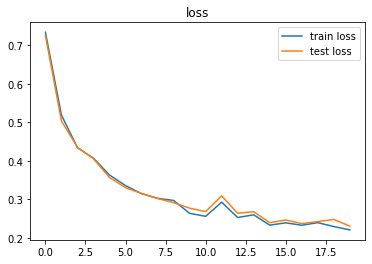

In [22]:
plt.figure()
plt.title('loss')
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()
plt.show()

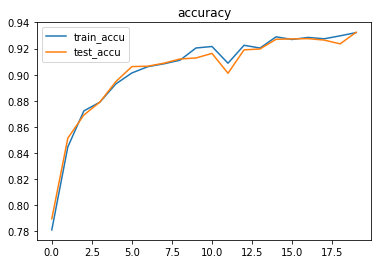

In [23]:
plt.figure()
plt.title("accuracy")
plt.plot(train_accu, label='train_accu')
plt.plot(test_accu, label='test_accu')
plt.legend()
plt.show()

In [24]:
def eval(model, loader):
    pre_arr = []
    tar_arr = []
    for inp, tar in loader:
        out = model(inp)
        pre = out.numpy().argmax(axis=1)
        pre_arr.append(pre)
        tar_arr.append(tar.numpy())
    pre_arr = np.concatenate(pre_arr)
    tar_arr = np.concatenate(tar_arr)
    return confusion_matrix(tar_arr, pre_arr)


In [25]:
cm = eval(model, test_ld)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()


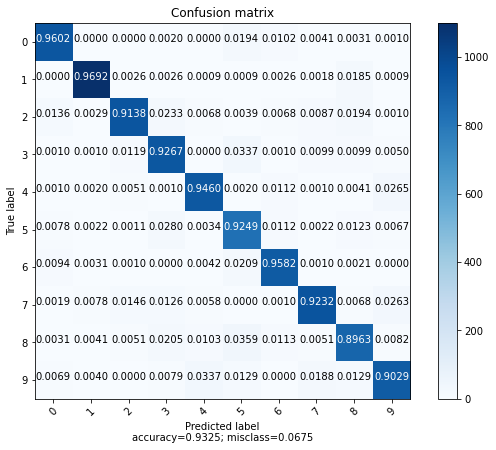

In [26]:
plot_confusion_matrix(cm, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])